# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
'''Levantamos la BBDD y observamos las caracteristicas generales de cada una de ellas'''
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('flujo-vehicular-2016.csv', sep =',')

Analizamos la composición de nuestro dataset

In [3]:
#data_2019.info()
#data_2019.head()

In [4]:
#data_2018.info()
#data_2018.head()

In [5]:
#data_2017.info()
#data_2017.head()

In [6]:
#data_2016.info()
#data_2016.head()

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [7]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())
print(data_2016['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [8]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())
print(data_2016['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [9]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())
print(data_2016['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [10]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())
print(data_2016['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']


##### Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


In [11]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset.head()

,fecha,hora_fin,dia,sentido,tipo_vehiculo,cantidad_pasos
80,2019-01-01,2,Martes,Centro,Liviano,537
86,2019-01-01,2,Martes,Centro,Pesado,1
88,2019-01-01,2,Martes,Provincia,Liviano,443
94,2019-01-01,2,Martes,Provincia,Pesado,1
149,2019-01-01,3,Martes,Centro,Liviano,769


In [12]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha2
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [13]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [14]:
#NULL
dataset.isnull().sum()

dia               0
sentido           0
tipo_vehiculo     0
cantidad_pasos    0
fecha             0
dtype: int64

### Parte A

**Para comenzar a realizar un analisis correcto es necesario definir primero cuales son los objetivos que tenemos.**
En dicho caso el objetivo es predecir el flujo vehicular de los proximos 90 días en la estación Illia con el medio de pago efectivo.
Como puntos principales vamos a intentar identificar patrones, estacionalidades, picos.
A su vez responder algunas preguntas como:
1. Cual es el comportamiento anualmente, mensualmente, diariamente?
1. Es el mismo por tipo de vehículo?

Respuesta a nuestra pregunta inicial.
1. Pesados y livianos anualmente: Disminuye la cantidad de pasos año tras año. En el inicio de 2019 una abrupta disminución de la cantidad de pasos. Mediante fuentes externas se detectó una fuerte suba en las tarifas lo que puede influir en la abrupta disminución de pasos
1. Pesados mensualmente: Enero y marzo meses fuertes, luego disminuye.
1. Livianos mensualmente: Muy heterogeneo. Pico en marzo y considerables disminuciones en los demás meses.
1. Pesados diariamente: De lunes a viernes aumenta progresivamente, luego sabados y domingos dismunuyen.
1. Livianos diariamente: De lunes a viernes aumenta progresivamente, luego sabados y domingos dismunuyen.

La siguiente es una nota informativa en la que se explica gran parte de los cambios producidos en 2019:
1. Aumento de precios
1. Descuento a transporte pesado mediante telepase, es decir, migración en el medio de pago.
1. Continúa el descuento para transporte liviano con telepase, es decir, migración en el medio de pago.
https://transitobuenosaires.com/aumento-de-peajes-caba-tarifas-actualizadas-a-enero-2019/

**La estructura de desarrollo del análisis de la información es la siguiente:**
1. Comenzamos con una análisis exploratorio de toda la información.
1. Luego procedemos a dividir nuestro dataset en livianos y pesados ya que consideramos que hay una diferencia en el comportamiento de ambos.
1. Realizamos un breve análisis exploratorio de ambos por separado.
1. Aplicamos un modelo benchmark.
1. Aplicamos nuestros modelos para predecir la cantidad de pasos en los 3 siguientes meses.

Los modelos aplicados son:
1. Benchmark regresión.
1. Random Forest Regressor
1. One step prediction
1. Multi step prediction

Preguntas que nos realizamos antes de empezar el análisis.
1. Cantidad de vehiculos en cada sentido.
1. Cantidad de pasos de cada tipo de vehículo.
1. Se puede analizarlos en la misma serie de tiempo?
1. Tienen estacionalidad?

Repuestas a nuestras preguntas iniciales:
1. Pregunta 1: Respuesta en el script.
1. Pregunta 2: Respuesta en el script.
1. No se puede analizar el tipo de vehiculo en la misma serie de tiempo ya que:
 1. No tienen el mismo flujo.
 1. No tienen los mismos días ni horarios pico.
 1. El comportamiento claramente no es el mismo.
 1. Además el Gobierno realiza una distinción entre ambos tipos de vehiculos por lo que no correspondería analizarlos de manera conjunta.
1. Si, poseen estacionalidad ambos tipo de vehículos.

In [15]:
dataset.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00


In [16]:
dataset_tipo_vehiculo = dataset.groupby([dataset.tipo_vehiculo])['cantidad_pasos'].sum().to_frame().reset_index().sort_values(by='cantidad_pasos', ascending=False)
dataset_tipo_vehiculo.cantidad_pasos=round(100*(dataset_tipo_vehiculo.cantidad_pasos/dataset_tipo_vehiculo.cantidad_pasos.sum()),1)

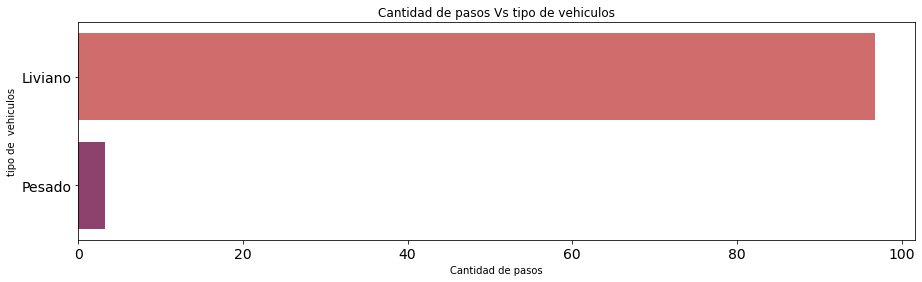

In [17]:
#Cantidad de vehiculos por tipo
plt.figure(figsize=(15, 4))
sns.barplot(y="tipo_vehiculo", 
            x="cantidad_pasos", 
            data=dataset_tipo_vehiculo,
            palette= "flare"
            )

#Formato de la gráfica
plt.title('Cantidad de pasos Vs tipo de vehiculos')
plt.xlabel('Cantidad de pasos')
plt.ylabel('tipo de  vehiculos')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

In [18]:
dataset_sentido = dataset.groupby([dataset.sentido])['cantidad_pasos'].sum().to_frame().reset_index().sort_values(by='cantidad_pasos', ascending=False)
dataset_sentido.cantidad_pasos=round(100*(dataset_sentido.cantidad_pasos/dataset_sentido.cantidad_pasos.sum()),1)

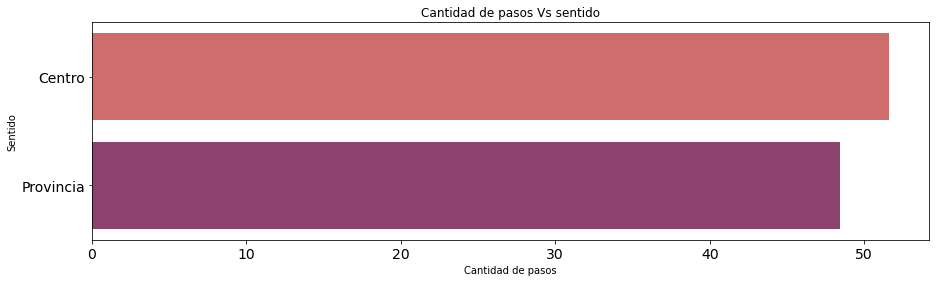

In [19]:
#Cantidad de pasos en los distintos sentidos por tipo de vehiculo
#Cantidad de vehiculos por tipo
plt.figure(figsize=(15, 4))
sns.barplot(y="sentido", 
            x="cantidad_pasos", 
            data=dataset_sentido,
            palette= "flare"
            )

#Formato de la gráfica
plt.title('Cantidad de pasos Vs sentido')
plt.xlabel('Cantidad de pasos')
plt.ylabel('Sentido')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

In [20]:
#Cantidad de vehiculos por día
dataset_dia = dataset.groupby([dataset.dia])['cantidad_pasos'].sum().reset_index().sort_values(by='cantidad_pasos', ascending=False)
dataset_dia.cantidad_pasos=round(100*(dataset_dia.cantidad_pasos/dataset_dia.cantidad_pasos.sum()),1)

Text(0, 0.5, 'Dias')

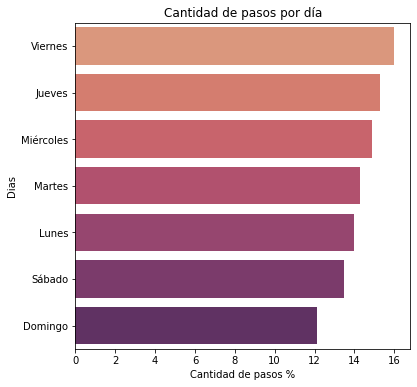

In [21]:
#Cantidad de pasos por tipo de vehiculo en los días de la semana.
plt.figure(figsize = (6,6))
sns.barplot(data=dataset_dia, y = 'dia', x ='cantidad_pasos', palette= "flare")

#Formato de la gráfica
plt.title('Cantidad de pasos por día')
plt.xlabel('Cantidad de pasos %')
plt.ylabel('Dias')

In [22]:
#Cantidad de pasos porcentualmente por día según tipo de vehiculo.
dataset.groupby(['dia','tipo_vehiculo'])[['cantidad_pasos']].count()/dataset.shape[0]*100

cantidad_pasos
dia       tipo_vehiculo                
Domingo   Liviano              5.235506
          Pesado               8.129142
Jueves    Liviano              5.212062
          Pesado               9.404318
Lunes     Liviano              5.240948
          Pesado               9.053079
Martes    Liviano              5.220435
          Pesado               9.153553
Miércoles Liviano              5.229226
          Pesado               9.425250
Sábado    Liviano              5.202014
          Pesado               8.760032
Viernes   Liviano              5.227133
          Pesado               9.507303

<AxesSubplot:xlabel='cantidad_pasos', ylabel='dia'>

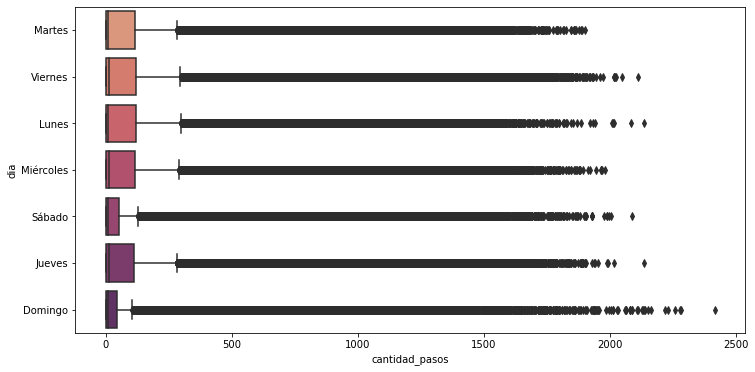

In [23]:
#Bloxplot para conocer si encontramos valores fuera de la caja.
plt.figure(figsize = (12,6))
sns.boxplot(data=dataset, x = 'cantidad_pasos',y ='dia', palette= "flare")

**Para un analisis mas preciso se toma la decision de analizar el dataset diferenciando por tipo de vehículo.**

**PESADO**

In [24]:
pesados = dataset[dataset['tipo_vehiculo']=="Pesado"]
pesados.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
86,Martes,Centro,Pesado,1,2019-01-01 02:00:00
94,Martes,Provincia,Pesado,1,2019-01-01 02:00:00
155,Martes,Centro,Pesado,7,2019-01-01 03:00:00
164,Martes,Provincia,Pesado,7,2019-01-01 03:00:00
291,Martes,Centro,Pesado,1,2019-01-01 05:00:00


In [25]:
pesados['día']= pesados['fecha'].dt.day
pesados['año']= pesados['fecha'].dt.year
pesados['mes']= pesados['fecha'].dt.month
pesados['hora']= pesados['fecha'].dt.hour

<ipython-input-25-caa5b9ca98a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pesados['día']= pesados['fecha'].dt.day
<ipython-input-25-caa5b9ca98a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pesados['año']= pesados['fecha'].dt.year
<ipython-input-25-caa5b9ca98a9>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [26]:
año_pesados = pesados.pivot_table(values = 'cantidad_pasos', index = ['año'], aggfunc = 'sum')
año_pesados = año_pesados.reset_index()
año_pesados.head()

,año,cantidad_pasos
0,2017,685710
1,2018,524820
2,2019,316522


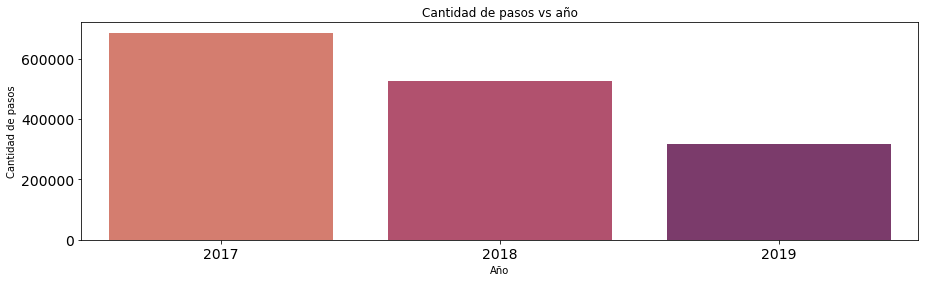

In [27]:
#Grafico diario
plt.figure(figsize=(12, 7))
sns.barplot(data=año_pesados,
            x = 'año',
            y = 'cantidad_pasos',
           palette= "flare",
           capsize=.2)

#Formato de la gráfica
plt.title('Cantidad de pasos vs año')
plt.ylabel('Cantidad de pasos')
plt.xlabel('Año')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

In [28]:
pesados_mes = pesados.pivot_table(values = 'cantidad_pasos', index = ['mes'], aggfunc = 'sum')
pesados_mes = pesados_mes.reset_index()
pesados_mes.index = ["Enero", "Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"]
pesados_mes.head(4)

,mes,cantidad_pasos
Enero,1,148513
Febrero,2,131618
Marzo,3,148734
Abril,4,133287


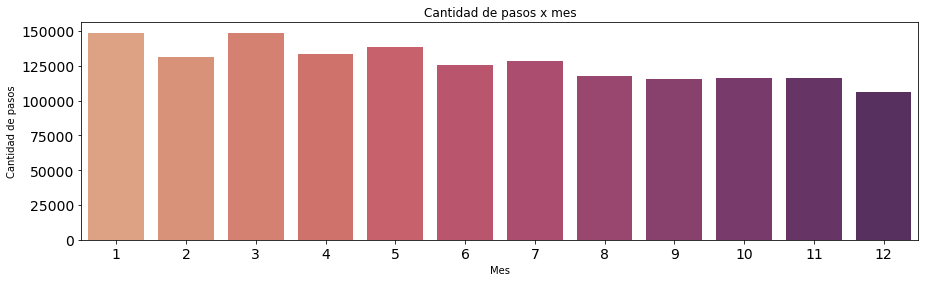

In [29]:
#Grafico diario
plt.figure(figsize=(15, 4))
sns.barplot(data = pesados_mes,
            x = 'mes',
            y = 'cantidad_pasos',
           palette= "flare")

#Formato de la gráfica
plt.title('Cantidad de pasos x mes')
plt.ylabel('Cantidad de pasos')
plt.xlabel('Mes')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

In [30]:
dia_pesados = pesados.pivot_table(values = 'cantidad_pasos', index = ['dia','año'], aggfunc = 'sum')
dia_pesados = dia_pesados.reset_index()
dia_pesados.head()

,dia,año,cantidad_pasos
0,Domingo,2017,50995
1,Domingo,2018,38295
2,Domingo,2019,29234
3,Jueves,2017,114189
4,Jueves,2018,89692


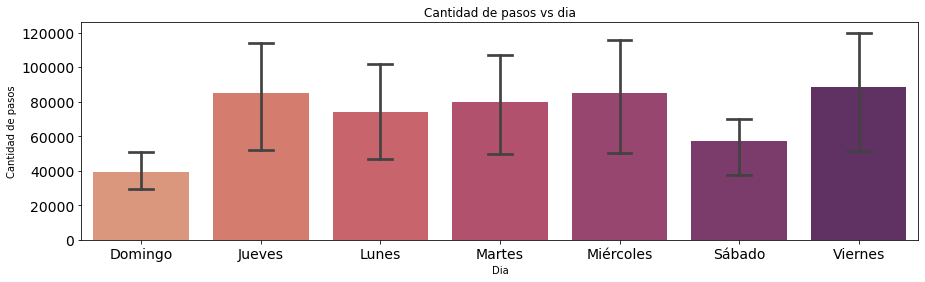

In [31]:
#Grafico diario
plt.figure(figsize=(15, 4))
sns.barplot(data=dia_pesados,
            x = 'dia',
            y = 'cantidad_pasos',
           palette= "flare",
           capsize=.2)

#Formato de la gráfica
plt.title('Cantidad de pasos vs dia')
plt.ylabel('Cantidad de pasos')
plt.xlabel('Dia')
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tick_params(labelsize=14)
plt.show()

Text(0.5, 0, 'Dia')

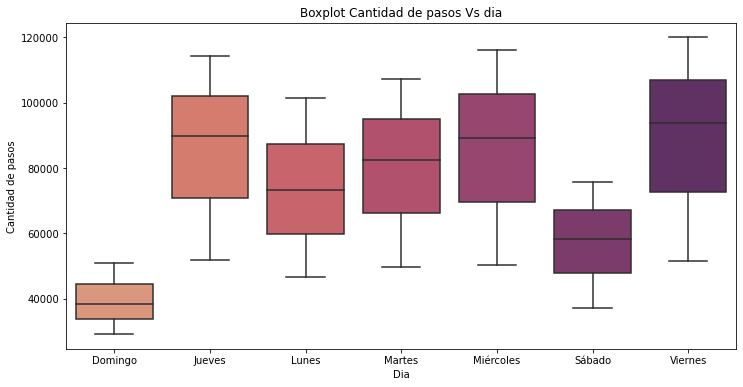

In [32]:
#Boxplot para conocer valores fuera de la caja.
figure(figsize=(12, 6))
sns.boxplot(data=dia_pesados, y = 'cantidad_pasos', x = 'dia', palette= "flare")

#Formato de la gráfica
plt.title('Boxplot Cantidad de pasos Vs dia')
plt.ylabel('Cantidad de pasos')
plt.xlabel('Dia')

In [33]:
pesados_hora = pesados.pivot_table(values = 'cantidad_pasos', index = ['dia', 'hora'], aggfunc = 'sum')
pesados_hora = pesados_hora.reset_index()
pesados_hora.head()

,dia,hora,cantidad_pasos
0,Domingo,0,3956
1,Domingo,1,2877
2,Domingo,2,2606
3,Domingo,3,2420
4,Domingo,4,2053


In [34]:
heat_map_pesados = pesados_hora.pivot_table(values = 'cantidad_pasos', index = 'dia', columns = 'hora')

Text(0.5, 1.0, 'Cantidad de pasos x hora (vehiculos pesados)')

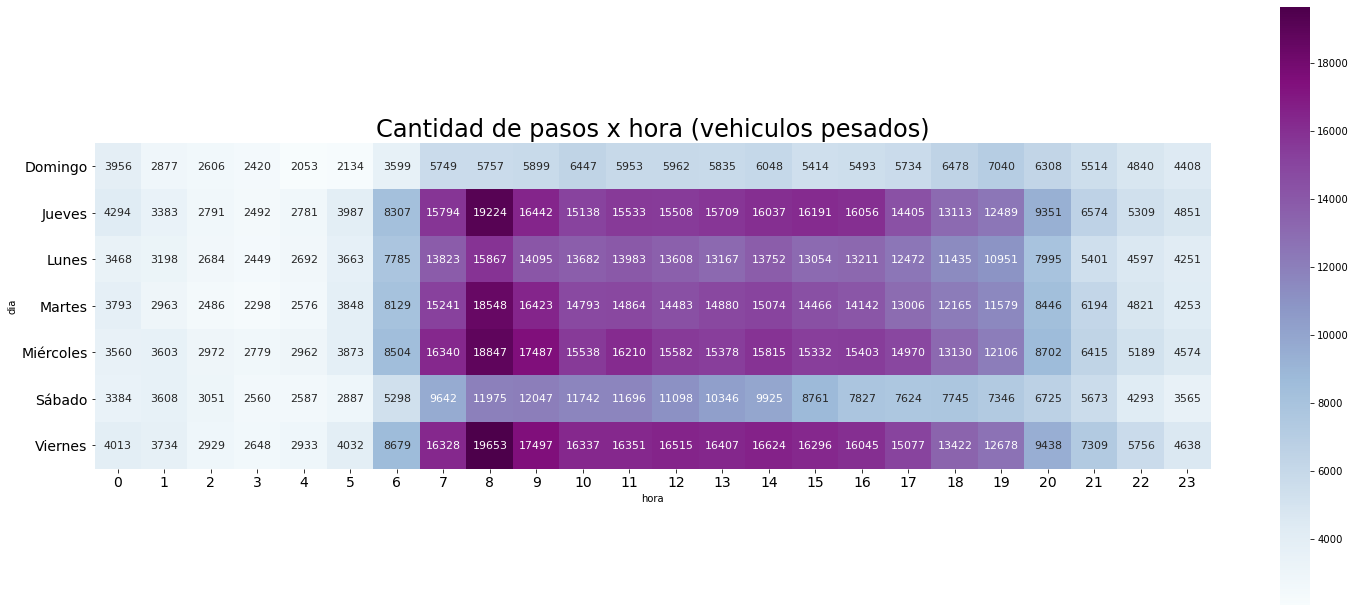

In [35]:
plt.figure(figsize = (25,11))
sns.heatmap(heat_map_pesados,
           cbar = True,
           square = True, 
           annot =True,
           fmt = '.0f',
           annot_kws = {'size':11},
           cmap="BuPu")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Cantidad de pasos x hora (vehiculos pesados)', fontsize = 24)

NOTA: Los pasos a lo largo de los años, mes a mes fue disminuyendo.

### Parte B
**Comenzamos a realizar el analisis con los datos resampleados.**

In [36]:
#Resampleamos nuestros datos para agrupar por mes, y asi tal vez lograr una visualización mas amigable
resampleo_pesados = pesados.resample('D', on = 'fecha')
diario_pesados_suma = resampleo_pesados.sum()
diario_pesados_media = resampleo_pesados.mean().round(2)
diario_pesados_suma.head()

,cantidad_pasos,día,año,mes,hora
fecha,,,,,
2017-01-01,542,137,276329,137,1858
2017-01-02,2589,438,441723,219,2592
2017-01-03,2771,633,425587,211,2469
2017-01-04,2751,900,453825,225,2805
2017-01-05,2864,1110,447774,222,2716


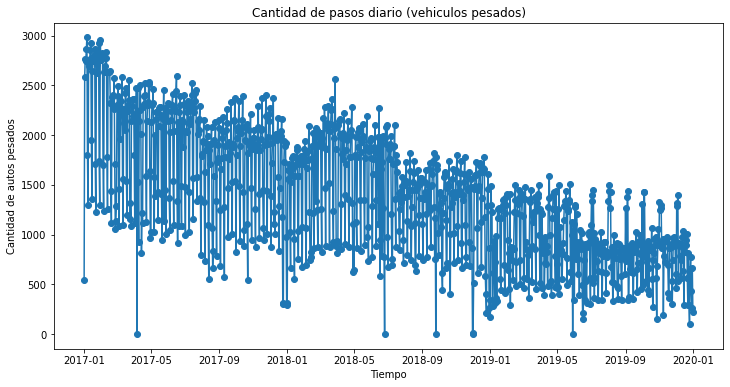

In [37]:
#Luego de resamplear graficamos la cantidad de pasadas por mes
plt.figure(figsize = (12,6))
plt.plot(diario_pesados_suma.index, diario_pesados_suma.cantidad_pasos, 'o-')

plt.title('Cantidad de pasos diario (vehiculos pesados)')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos pesados')
plt.show()

In [38]:
#Aplicamos interpolate, considerando como atípico los pasos menores a 30000 y con una media menor a 250 pasos.
diario_pesados_suma[diario_pesados_suma < 400] = np.nan
diario_pesados_suma[diario_pesados_suma > 2800] = np.nan
diario_pesados_suma = diario_pesados_suma.interpolate()

In [39]:
pesados_year_sum = pesados.groupby([pesados['fecha'].dt.year, pesados['fecha'].dt.month]).sum()
pesados_year_sum.head()

cantidad_pasos     día       año    mes   hora
fecha fecha                                                
2017  1               74267  107579  13382795   6635  81092
      2               60495   84366  11898283  11798  71351
      3               62274   98570  12454975  18525  75931
      4               55819   89767  11430339  22668  69339
      5               58031   94244  11920470  29550  72530

In [40]:
ventana_pesado = int(365/2)
mes_promedio_pesado = diario_pesados_suma.rolling(window=ventana_pesado, center = True).mean()
mes_promedio_pesado.head()

,cantidad_pasos,día,año,mes,hora
fecha,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN


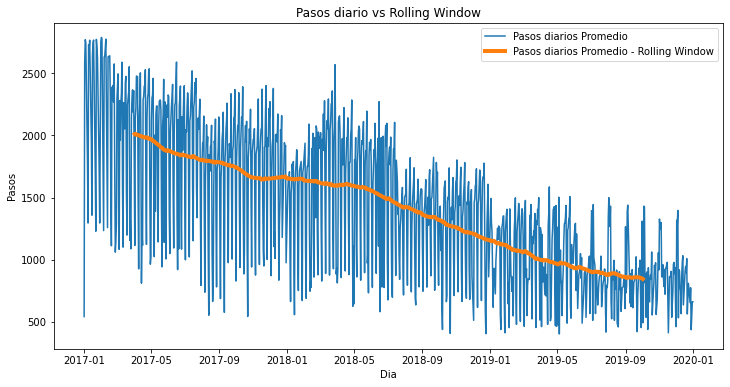

In [41]:
#Graficamos nuestra serie original y la rolling window
plt.figure(figsize = (12,6))
plt.plot(diario_pesados_suma.index, diario_pesados_suma.cantidad_pasos, label = 'Pasos diarios Promedio')
plt.plot(mes_promedio_pesado.cantidad_pasos, lw = 4, label = 'Pasos diarios Promedio - Rolling Window')

plt.title('Pasos diario vs Rolling Window')
plt.xlabel('Dia')
plt.ylabel('Pasos')
plt.legend()
plt.show()

Tendencia Lineal-Benchmark

Este método consiste en ajustar una regresión lineal a la serie.

In [42]:
diario_pesados_suma['fecha_numeros']=diario_pesados_suma.index.map(datetime.datetime.toordinal)
diario_pesados_suma.head()

,cantidad_pasos,día,año,mes,hora,fecha_numeros
fecha,,,,,,
2017-01-01,542.000000,NaN,NaN,NaN,1858.0,736330
2017-01-02,2589.000000,438.0,NaN,NaN,2592.0,736331
2017-01-03,2771.000000,633.0,NaN,NaN,2469.0,736332
2017-01-04,2751.000000,900.0,NaN,NaN,2592.5,736333
2017-01-05,2432.666667,1110.0,NaN,NaN,2716.0,736334


In [43]:
#Benchmark
from sklearn.linear_model import LinearRegression
lr_pesado = LinearRegression()
lr_pesado.fit(diario_pesados_suma.fecha_numeros.values.reshape(-1, 1), diario_pesados_suma.cantidad_pasos)

LinearRegression()

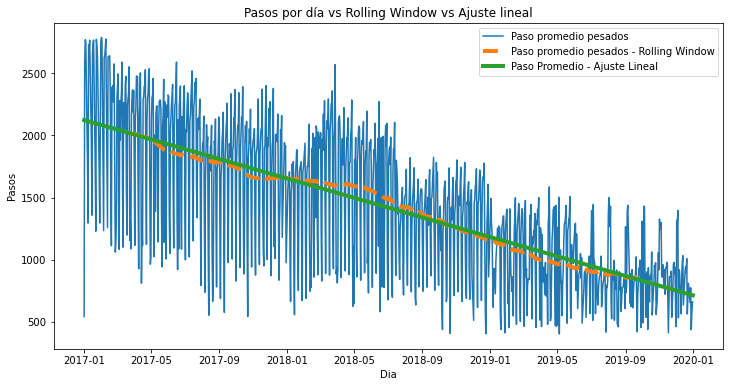

In [44]:
#Graficamos nuestra serie original, la rolling window y el ajuste lineal.
plt.figure(figsize = (12,6))
plt.plot(diario_pesados_suma.index, diario_pesados_suma.cantidad_pasos, label = 'Paso promedio pesados')
plt.plot(mes_promedio_pesado.cantidad_pasos, ls = '--', lw = 4, label = 'Paso promedio pesados - Rolling Window')
plt.plot(diario_pesados_suma.index, lr_pesado.predict(diario_pesados_suma.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Paso Promedio - Ajuste Lineal')

plt.title('Pasos por día vs Rolling Window vs Ajuste lineal')
plt.xlabel('Dia')
plt.ylabel('Pasos')
plt.legend()
plt.show()

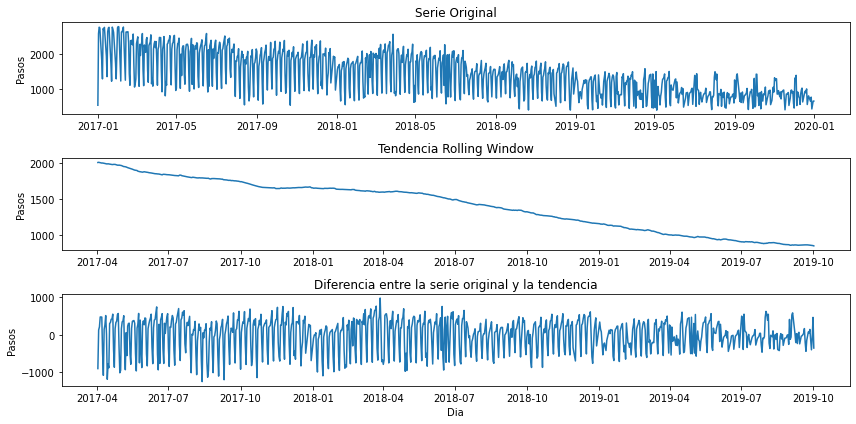

In [45]:
#Graficamos por separado la serie original, rolling window y la diferencia entre ambas.
plt.figure(figsize = (12,6))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario_pesados_suma.index, diario_pesados_suma.cantidad_pasos)
plt.ylabel('Pasos')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(mes_promedio_pesado.cantidad_pasos)
plt.ylabel('Pasos')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(diario_pesados_suma.index, diario_pesados_suma.cantidad_pasos - mes_promedio_pesado.cantidad_pasos)
plt.xlabel('Dia')
plt.ylabel('Pasos')

plt.tight_layout()
plt.show()

In [46]:
#Aplicamos un metodo de descomposición con statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

result_pesado = seasonal_decompose(diario_pesados_suma.cantidad_pasos, model='additive',extrapolate_trend='freq')

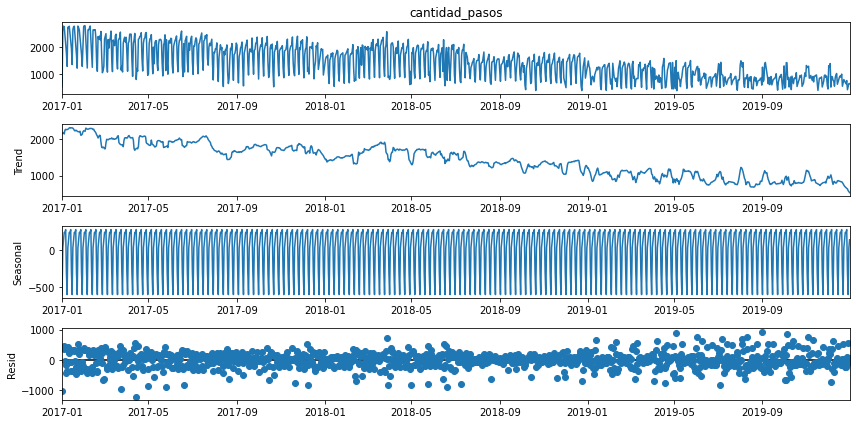

In [47]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12,6]
result_pesado.plot()
plt.show()

Text(0.5, 1.0, 'Histograma residuos')

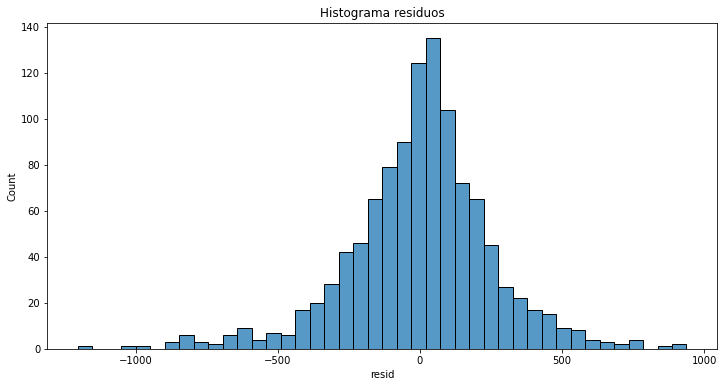

In [48]:
#Histograma del residuo.
figure(figsize=(12, 6))
sns.histplot(result_pesado.resid)

plt.title('Histograma residuos')

### Parte B pesados.

### One-Step prediction pesados.

In [49]:
senial_pesados = diario_pesados_suma.cantidad_pasos
senial_pesados.head()

fecha
2017-01-01     542.000000
2017-01-02    2589.000000
2017-01-03    2771.000000
2017-01-04    2751.000000
2017-01-05    2432.666667
Freq: D, Name: cantidad_pasos, dtype: float64

In [50]:
#Definimos un lookback
look_back_pesados = 225

In [51]:
N_pes = senial_pesados.shape[0]
X_pes = np.zeros((N_pes - look_back_pesados - 1,look_back_pesados))
y_pes = np.zeros(N_pes - look_back_pesados - 1)
print(X_pes.shape, y_pes.shape)

(869, 225) (869,)


In [52]:
for i in range(X_pes.shape[0]):
    X_pes[i,:] = senial_pesados.iloc[i:i+look_back_pesados]
    y_pes[i] = senial_pesados.iloc[i+look_back_pesados]

In [53]:
#print(X_pes)

In [54]:
#print(y_pes)

In [55]:
N_train_pesado = 750 # cantidad de instancias que vamos a usar para entrenar. 
N_test_pesado = 90 #cantidad de puntos que vamos a usar para evaluar
N_total_pesado = N_train_pesado + N_test_pesado

length_total_pesado = N_train_pesado + N_test_pesado + look_back_pesados

X_train_pesado =X_pes[:N_train_pesado,:]
y_train_pesado = y_pes[:N_train_pesado]
print(X_train_pesado.shape, y_train_pesado.shape)

X_test_pes = X_pes[N_train_pesado:N_train_pesado+N_test_pesado,:]
y_test_pes = y_pes[N_train_pesado:N_train_pesado+N_test_pesado]
print(X_test_pes.shape, y_test_pes.shape)

(750, 225) (750,)
(90, 225) (90,)


**Random Forest regressor pesados**

In [56]:
forest_pesados = RandomForestRegressor()

In [57]:
#Optimizacion de hiperparametros
'''HIPERPARAMETROS DE NUESTRO RANDOM FOREST'''
param = {'max_depth': [3,9,13,15],
         'n_estimators' : [100],
        'max_features': ['auto', 'sqrt', 'log2']}

In [58]:
rf_pesados = RandomizedSearchCV(forest_pesados, param,n_iter=10, random_state=42, cv=4, n_jobs = -1).fit(X_train_pesado,y_train_pesado)

In [59]:
print("Mejores parametros del modelo random forest: "+str(rf_pesados.best_params_))
print("Mejor Score: "+str(rf_pesados.best_score_.round(3))+'\n')

Mejores parametros del modelo random forest: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 15}
Mejor Score: 0.53



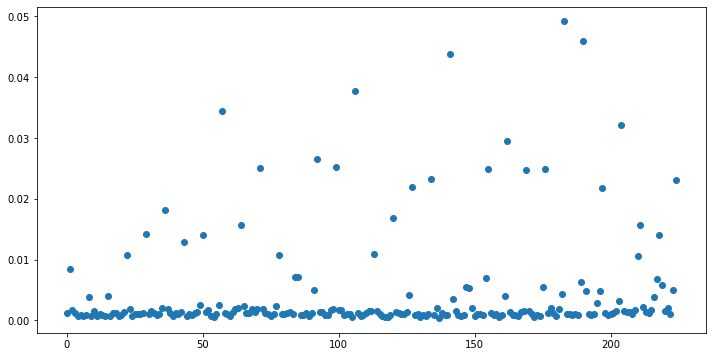

In [60]:
plt.figure(figsize = (12,6))
plt.scatter(np.arange(rf_pesados.best_estimator_.feature_importances_.size),rf_pesados.best_estimator_.feature_importances_)
plt.show()

In [61]:
y_pred_pes = rf_pesados.predict(X_pes)
y_train_pred_pes = rf_pesados.predict(X_train_pesado)
y_test_pred_pes = rf_pesados.predict(X_test_pes)

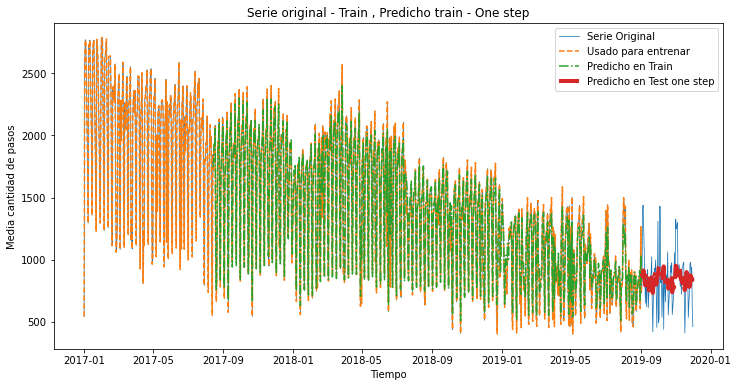

In [62]:
plt.figure(figsize=(12,6))
plt.plot(senial_pesados.index[:length_total_pesado], senial_pesados[:length_total_pesado],lw = 0.75, label = 'Serie Original')
plt.plot(senial_pesados.index[:N_train_pesado + look_back_pesados], senial_pesados[:N_train_pesado + look_back_pesados],'--', label = 'Usado para entrenar')
plt.plot(senial_pesados.index[look_back_pesados: look_back_pesados + N_train_pesado], y_train_pred_pes,'-.',label = 'Predicho en Train')
plt.plot(senial_pesados.index[N_train_pesado+look_back_pesados: length_total_pesado], y_test_pred_pes,'-.', lw = 4, label = 'Predicho en Test one step')
plt.legend()

plt.title('Serie original - Train , Predicho train - One step')
plt.xlabel('Tiempo')
plt.ylabel('Media cantidad de pasos')
plt.show()

In [63]:
#Benchmark
y_test_pred_benchmark = y_pes[-1 + N_train_pesado:N_train_pesado+N_test_pesado - 1]

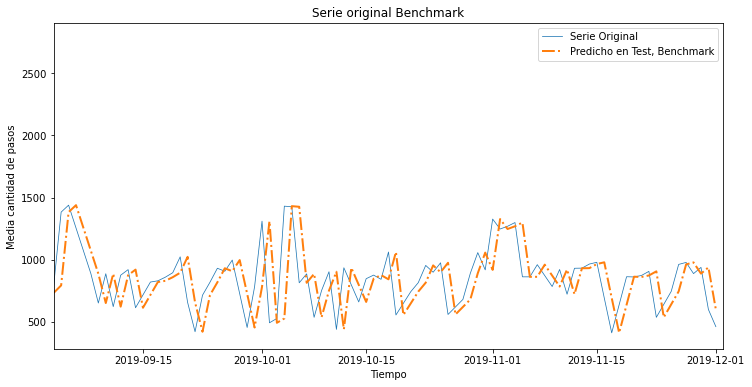

In [64]:
plt.figure(figsize=(12,6))
plt.plot(senial_pesados.index[:length_total_pesado], senial_pesados[:length_total_pesado],lw = 0.75, label = 'Serie Original')
plt.plot(senial_pesados.index[N_train_pesado+look_back_pesados: length_total_pesado], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial_pesados.index[N_train_pesado+look_back_pesados], senial_pesados.index[length_total_pesado])

plt.title('Serie original Benchmark')
plt.xlabel('Tiempo')
plt.ylabel('Media cantidad de pasos')
plt.legend()
plt.show()

### Multi-Step Prediction

Con el modelo ya entrenado, vamos a usar el método recursivo para hacer Multi-Step prediction.

In [65]:
y_ms_test_pred_pes = []
x = X_test_pes[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test_pes.size):
    y_os_pred = rf_pesados.predict(x.reshape(1,-1))
    y_ms_test_pred_pes.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred_pes = np.array(y_ms_test_pred_pes)

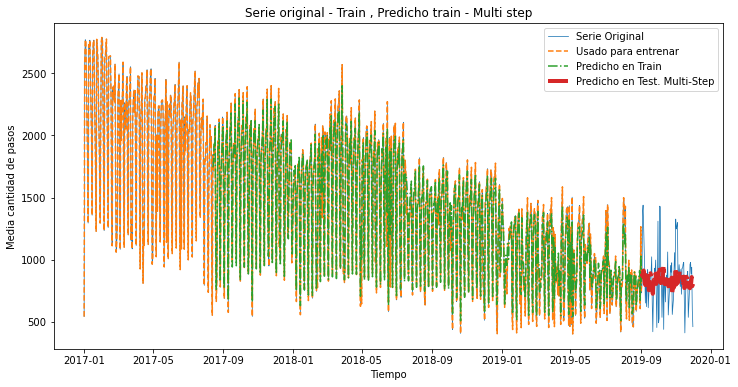

In [66]:
plt.figure(figsize=(12,6))
plt.plot(senial_pesados.index[:length_total_pesado], senial_pesados[:length_total_pesado],lw = 0.75, label = 'Serie Original')
plt.plot(senial_pesados.index[:N_train_pesado + look_back_pesados], senial_pesados[:N_train_pesado + look_back_pesados],'--', label = 'Usado para entrenar')
plt.plot(senial_pesados.index[look_back_pesados: look_back_pesados + N_train_pesado], y_train_pred_pes,'-.',label = 'Predicho en Train')
plt.plot(senial_pesados.index[N_train_pesado+look_back_pesados: length_total_pesado], y_ms_test_pred_pes,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()

plt.title('Serie original - Train , Predicho train - Multi step')
plt.xlabel('Tiempo')
plt.ylabel('Media cantidad de pasos')
plt.show()

In [67]:
#Presentamos el error cuadratico medio de cada uno.

MSE_train_pes = mean_squared_error(y_train_pesado, y_train_pred_pes)
print('El error cuadratico medio en Train de los vehiculos pesados es de:',np.sqrt(MSE_train_pes).round(3))

MSE_test_pes = mean_squared_error(y_test_pes, y_test_pred_pes)
print('El error cuadratico medio en Test de los vehiculos pesados es de:',np.sqrt(MSE_test_pes).round(3))

y_test_pred_benchmark = y_pes[-1 + N_train_pesado:N_train_pesado+N_test_pesado - 1]
MSE_test_benchmark_pes = mean_squared_error(y_test_pes, y_pes[-1 + N_train_pesado:N_train_pesado+N_test_pesado - 1])
print('El error cuadratico medio en Test benchmark de los vehiculos pesados es de:',np.sqrt(MSE_test_benchmark_pes).round(3))

MSE_test_multistep_pes = mean_squared_error(y_test_pes, y_ms_test_pred_pes)
print('El error cuadratico medio con el metodo multi-step en test es de: ',np.sqrt(MSE_test_multistep_pes).round(3))

El error cuadratico medio en Train de los vehiculos pesados es de: 90.735
El error cuadratico medio en Test de los vehiculos pesados es de: 213.479
El error cuadratico medio en Test benchmark de los vehiculos pesados es de: 258.511
El error cuadratico medio con el metodo multi-step en test es de:  220.279


**LIVIANO**

In [68]:
livianos = dataset.tipo_vehiculo=='Liviano'
livianos = dataset[livianos]
livianos.head()

,dia,sentido,tipo_vehiculo,cantidad_pasos,fecha
80,Martes,Centro,Liviano,537,2019-01-01 02:00:00
88,Martes,Provincia,Liviano,443,2019-01-01 02:00:00
149,Martes,Centro,Liviano,769,2019-01-01 03:00:00
158,Martes,Provincia,Liviano,597,2019-01-01 03:00:00
223,Martes,Centro,Liviano,597,2019-01-01 04:00:00


In [69]:
livianos['día']= livianos['fecha'].dt.day
livianos['año']= livianos['fecha'].dt.year
livianos['mes']= livianos['fecha'].dt.month
livianos['hora']= livianos['fecha'].dt.hour

<ipython-input-69-b2ddada962bf>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  livianos['día']= livianos['fecha'].dt.day
<ipython-input-69-b2ddada962bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  livianos['año']= livianos['fecha'].dt.year
<ipython-input-69-b2ddada962bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [70]:
año_livianos = livianos.pivot_table(values = 'cantidad_pasos', index = ['año'], aggfunc = 'sum')
año_livianos = año_livianos.reset_index()
año_livianos.head()

,año,cantidad_pasos
0,2017,17097802
1,2018,15442124
2,2019,13798603


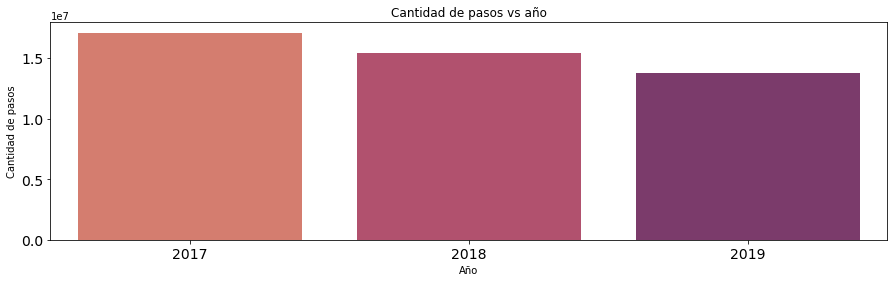

In [71]:
#Grafico diario
plt.figure(figsize=(15, 4))
sns.barplot(data=año_livianos,
            x = 'año',
            y = 'cantidad_pasos',
           palette= "flare",
           capsize=.2)

#Formato de la gráfica
plt.title('Cantidad de pasos vs año')
plt.ylabel('Cantidad de pasos')
plt.xlabel('Año')
plt.tick_params(labelsize=14)
plt.show()

In [72]:
liviano_mes = livianos.pivot_table(values = 'cantidad_pasos', index = ['mes'], aggfunc = 'sum')
liviano_mes = liviano_mes.reset_index()
liviano_mes.index = ["Enero", "Febrero","Marzo","Abril","Mayo","Junio","Julio","Agosto","Septiembre","Octubre","Noviembre","Diciembre"]
liviano_mes.head()

,mes,cantidad_pasos
Enero,1,3981437
Febrero,2,3673667
Marzo,3,4102845
Abril,4,3774091
Mayo,5,3832578


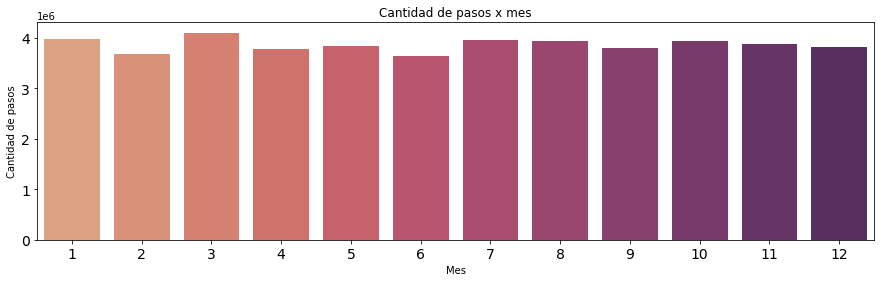

In [73]:
#Grafico diario
plt.figure(figsize=(15, 4))
sns.barplot(data = liviano_mes,
            x = 'mes',
            y = 'cantidad_pasos',
           palette = 'flare')

#Formato de la gráfica
plt.title('Cantidad de pasos x mes')
plt.ylabel('Cantidad de pasos')
plt.xlabel('Mes')
plt.tick_params(labelsize=14)
plt.show()

In [74]:
dia_livianos = livianos.pivot_table(values = 'cantidad_pasos', index = ['dia','año'], aggfunc = 'sum')
dia_livianos = dia_livianos.reset_index()
dia_livianos.head()

,dia,año,cantidad_pasos
0,Domingo,2017,2016522
1,Domingo,2018,1856088
2,Domingo,2019,1800827
3,Jueves,2017,2610957
4,Jueves,2018,2374030


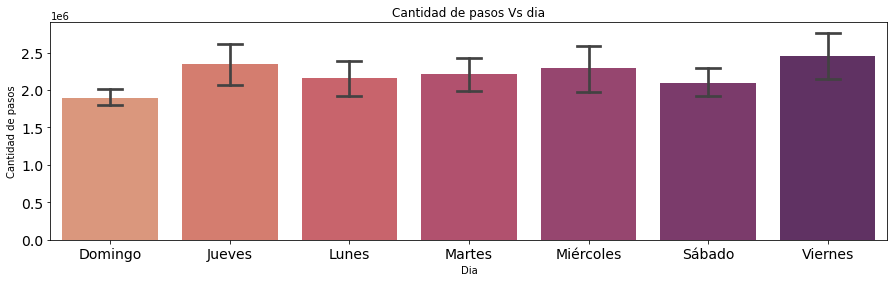

In [75]:
#Grafico diario
plt.figure(figsize=(15, 4))
sns.barplot(data=dia_livianos,
            x = 'dia',
            y = 'cantidad_pasos',
           palette= "flare",
           capsize=.2)

#Formato de la gráfica
plt.title('Cantidad de pasos Vs dia')
plt.ylabel('Cantidad de pasos')
plt.xlabel('Dia')
plt.tick_params(labelsize=14)
plt.show()

Text(0.5, 1.0, 'Boxplot pasos diarios')

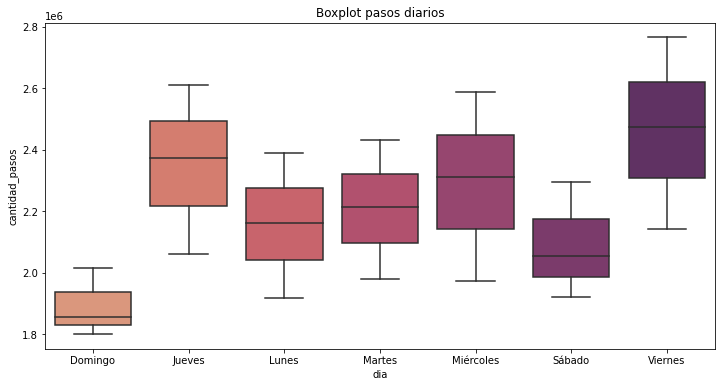

In [76]:
#Boxplot para conocer valores fuera de la caja.
figure(figsize=(12, 6))
sns.boxplot(data=dia_livianos, y = 'cantidad_pasos', x = 'dia', palette= "flare")
plt.title('Boxplot pasos diarios')

In [77]:
livianos_hora = livianos.pivot_table(values = 'cantidad_pasos', index = ['dia', 'hora'], aggfunc = 'sum')
livianos_hora = livianos_hora.reset_index()
livianos_hora.head()

,dia,hora,cantidad_pasos
0,Domingo,0,171547
1,Domingo,1,172015
2,Domingo,2,156330
3,Domingo,3,124073
4,Domingo,4,82165


In [78]:
heat_map_livianos = livianos_hora.pivot_table(values = 'cantidad_pasos', index = 'dia', columns = 'hora')

Text(0.5, 1.0, 'Cantidad de pasos x hora (vehiculos livianos)')

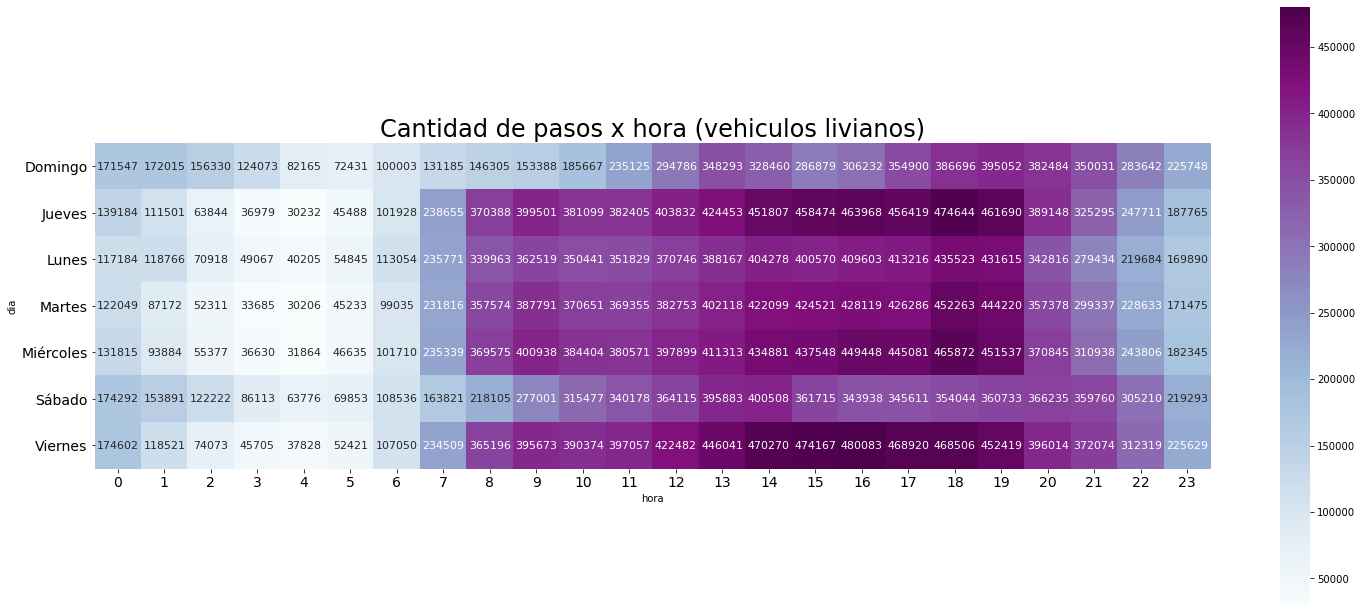

In [79]:
plt.figure(figsize = (25,11))
sns.heatmap(heat_map_livianos,
           cbar = True,
           square = True, 
           annot =True,
           fmt = '.0f',
           annot_kws = {'size':11},
           cmap="BuPu")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Cantidad de pasos x hora (vehiculos livianos)', fontsize = 24)

### Parte B livianos.

In [80]:
resample_livianos = livianos.resample('D', on = 'fecha')
diario_livianos_suma = resample_livianos.sum()
diario_livianos_media = resample_livianos.mean().round(2)

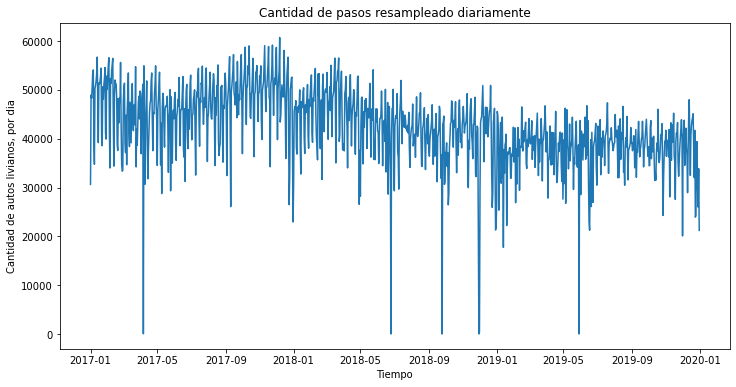

In [81]:
#Visualizamos la cantidad de pasos una vez resampleado diariamente.
plt.figure(figsize = (12,6))
plt.plot(diario_livianos_suma.index, diario_livianos_suma.cantidad_pasos)

plt.title('Cantidad de pasos resampleado diariamente')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos livianos, por dia')
plt.show()

In [82]:
#Aplicamos interpolate, considerando como atípico los pasos menores a 27000.
diario_livianos_suma[diario_livianos_suma < 27000] = np.nan
diario_livianos_suma = diario_livianos_suma.interpolate()

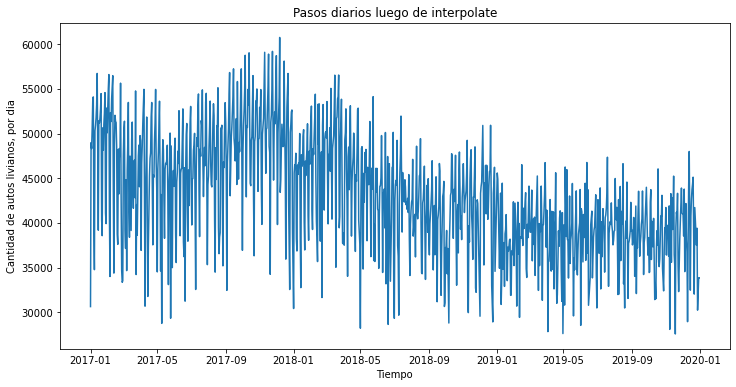

In [83]:
#Resultado luego de aplicar el interpolate.
plt.figure(figsize = (12,6))
plt.plot(diario_livianos_suma.index, diario_livianos_suma.cantidad_pasos)

plt.title('Pasos diarios luego de interpolate')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos livianos, por dia')
plt.show()

In [84]:
livianos_year = livianos.groupby([livianos['fecha'].dt.year, livianos['fecha'].dt.month]).sum()
livianos_year.head()

cantidad_pasos    día      año    mes   hora
fecha fecha                                              
2017  1             1490993  47961  6034864   2992  34460
      2             1302618  39171  5451951   5406  31116
      3             1388940  47640  6014694   8946  34369
      4             1318166  44127  5627430  11160  32178
      5             1349105  47415  5966286  14790  34055

In [85]:
#Reordenamos el dataset por fecha
livianos.sort_values('fecha', inplace = True)
livianos.reset_index(drop=True, inplace = True)
livianos.set_index('fecha', inplace = True)

<ipython-input-85-d2ac5ae4aedb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  livianos.sort_values('fecha', inplace = True)


In [86]:
#Aplicamos una ventana de tiempo.
ventana_liviano = int(365/2)
diario_promedio_liviano = diario_livianos_suma.rolling(window=ventana_liviano, center = True).mean()
diario_promedio_liviano.head()

,cantidad_pasos,día,año,mes,hora
fecha,,,,,
2017-01-01,NaN,NaN,NaN,NaN,NaN
2017-01-02,NaN,NaN,NaN,NaN,NaN
2017-01-03,NaN,NaN,NaN,NaN,NaN
2017-01-04,NaN,NaN,NaN,NaN,NaN
2017-01-05,NaN,NaN,NaN,NaN,NaN


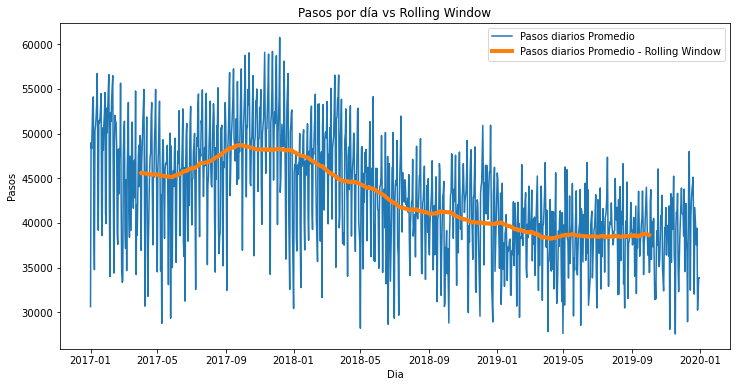

In [87]:
#Graficamos los pasos díarios y la rolling window.
plt.figure(figsize = (12,6))
plt.plot(diario_livianos_suma.index, diario_livianos_suma.cantidad_pasos, label = 'Pasos diarios Promedio')
plt.plot(diario_promedio_liviano.cantidad_pasos, lw = 4, label = 'Pasos diarios Promedio - Rolling Window')

plt.title('Pasos por día vs Rolling Window')
plt.xlabel('Dia')
plt.ylabel('Pasos')
plt.legend()
plt.show()

Tendencia Lineal- Benchmark

Este método consiste simplemente en ajustar una regresión lineal a la serie

In [88]:
diario_livianos_suma['fecha_numeros']=diario_livianos_suma.index.map(datetime.datetime.toordinal)
diario_livianos_suma.head()

,cantidad_pasos,día,año,mes,hora,fecha_numeros
fecha,,,,,,
2017-01-01,30641.0,NaN,189598.0,NaN,NaN,736330
2017-01-02,48979.0,NaN,195649.0,NaN,NaN,736331
2017-01-03,48322.0,NaN,193632.0,NaN,NaN,736332
2017-01-04,50581.0,NaN,193632.0,NaN,NaN,736333
2017-01-05,53622.0,NaN,193632.0,NaN,NaN,736334


In [89]:
#Benchmark
from sklearn.linear_model import LinearRegression
lr_liviano = LinearRegression()
lr_liviano.fit(diario_livianos_suma.fecha_numeros.values.reshape(-1, 1), diario_livianos_suma.cantidad_pasos)

LinearRegression()

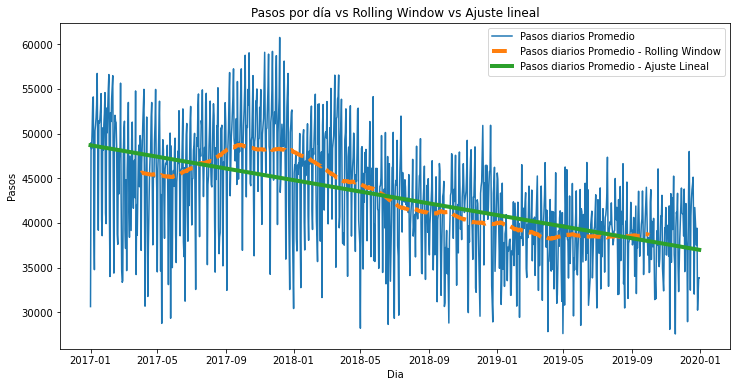

In [90]:
#Graficamos nuestra serie original, la rolling window y el ajuste lineal.
plt.figure(figsize = (12,6))
plt.plot(diario_livianos_suma.index, diario_livianos_suma.cantidad_pasos, label = 'Pasos diarios Promedio')
plt.plot(diario_promedio_liviano.cantidad_pasos, ls = '--', lw = 4, label = 'Pasos diarios Promedio - Rolling Window')
plt.plot(diario_livianos_suma.index, lr_liviano.predict(diario_livianos_suma.fecha_numeros.values.reshape(-1, 1)), lw = 4, label = 'Pasos diarios Promedio - Ajuste Lineal')

plt.title('Pasos por día vs Rolling Window vs Ajuste lineal')
plt.xlabel('Dia')
plt.ylabel('Pasos')
plt.legend()
plt.show()

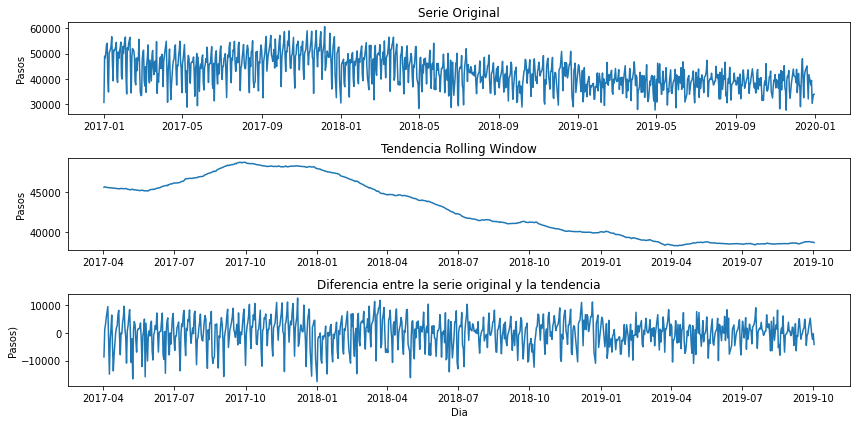

In [91]:
#Graficamos nuestra serie original, la rolling window y la diferencia entre ambas.
plt.figure(figsize = (12,6))

plt.subplot(3,1,1)
plt.title('Serie Original')
plt.plot(diario_livianos_suma.index, diario_livianos_suma.cantidad_pasos)
plt.ylabel('Pasos')

plt.subplot(3,1,2)
plt.title('Tendencia Rolling Window')
plt.plot(diario_promedio_liviano.cantidad_pasos)
plt.ylabel('Pasos')

plt.subplot(3,1,3)
plt.title('Diferencia entre la serie original y la tendencia')
plt.plot(diario_livianos_suma.index, diario_livianos_suma.cantidad_pasos - diario_promedio_liviano.cantidad_pasos)
plt.xlabel('Dia')
plt.ylabel('Pasos)')

plt.tight_layout()
plt.show()

In [92]:
#Aplicamos un metodo de descomposición con statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

result_liviano = seasonal_decompose(diario_livianos_suma.cantidad_pasos, model='additive',extrapolate_trend='freq')

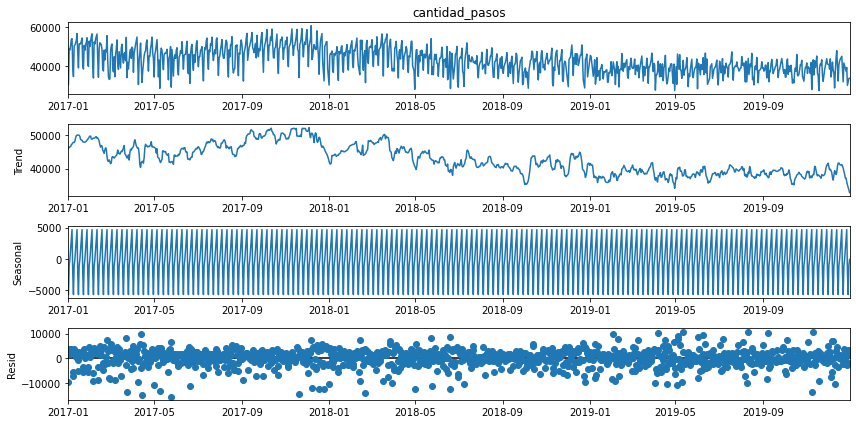

In [93]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [12,6]
result_liviano.plot()
plt.show()

Text(0.5, 1.0, 'Residuo livianos')

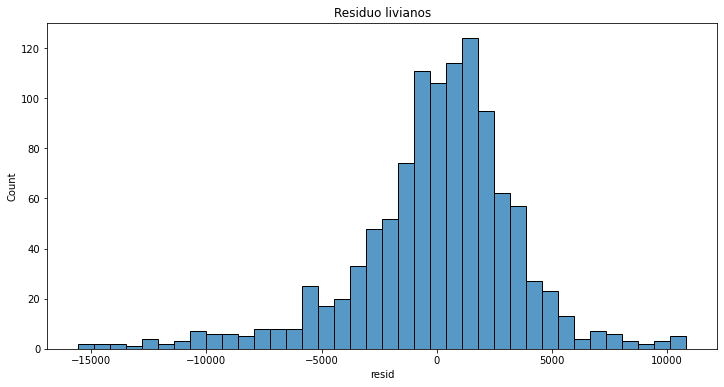

In [94]:
#Histograma del residuo
figure(figsize=(12, 6))
sns.histplot(result_liviano.resid)
plt.title('Residuo livianos')

### One-Step prediction livianos.

In [95]:
senial_livianos = diario_livianos_suma.cantidad_pasos
senial_livianos.head()

fecha
2017-01-01    30641.0
2017-01-02    48979.0
2017-01-03    48322.0
2017-01-04    50581.0
2017-01-05    53622.0
Freq: D, Name: cantidad_pasos, dtype: float64

In [96]:
#Definimos un lookback
look_back_livianos = 225

In [97]:
N_liv = senial_livianos.shape[0]
X_liv = np.zeros((N_liv - look_back_livianos - 1,look_back_livianos)) 
y_liv = np.zeros(N_liv - look_back_livianos - 1) 
print(X_liv.shape, y_liv.shape)

(869, 225) (869,)


In [98]:
for i in range(X_liv.shape[0]):
    X_liv[i,:] = senial_livianos.iloc[i:i+look_back_livianos]
    y_liv[i] = senial_livianos.iloc[i+look_back_livianos]

In [99]:
#print(X_liv)

In [100]:
#print(y_liv)

In [101]:
N_train_liviano = 1003 - look_back_livianos# cantidad de instancias que vamos a usar para entrenar. 
N_test_liviano = 91 #cantidad de puntos que vamos a usar para evaluar
N_total_liviano = N_train_liviano + N_test_liviano

length_total_liviano = N_train_liviano + N_test_liviano + look_back_livianos

X_train_liviano =X_liv[:N_train_liviano,:]
y_train_liviano = y_liv[:N_train_liviano]
print(X_train_liviano.shape, y_train_liviano.shape)

X_test_liv = X_liv[N_train_liviano:N_train_liviano+N_test_liviano,:]
y_test_liv = y_liv[N_train_liviano:N_train_liviano+N_test_liviano]
print(X_test_liv.shape, y_test_liv.shape)

(778, 225) (778,)
(91, 225) (91,)


**Random Forest Regressor**

In [102]:
#Randon forest livianos
forest_livianos = RandomForestRegressor()

In [103]:
#Optimizacion de hiperparametros
'''HIPERPARAMETROS DE NUESTRO RANDOM FOREST'''
param = {'max_depth': [3,9,13,15],
         'n_estimators' : [100],
        'max_features': ['auto', 'sqrt', 'log2']}

In [104]:
rf_livianos = RandomizedSearchCV(forest_livianos, param,n_iter=10, random_state=42, cv=2, n_jobs = -1).fit(X_train_liviano,y_train_liviano)

In [105]:
print("Mejores parametros del modelo random forest: "+str(rf_livianos.best_params_))
print("Mejor Score: "+str(rf_livianos.best_score_.round(3))+'\n')

Mejores parametros del modelo random forest: {'n_estimators': 100, 'max_features': 'auto', 'max_depth': 15}
Mejor Score: 0.033



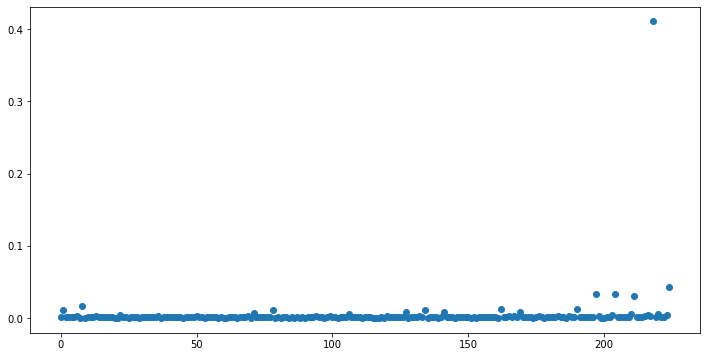

In [106]:
plt.figure(figsize = (12,6))
plt.scatter(np.arange(rf_livianos.best_estimator_.feature_importances_.size),rf_livianos.best_estimator_.feature_importances_)
plt.show()

In [107]:
y_pred_liv = rf_livianos.predict(X_liv)
y_train_pred_liv = rf_livianos.predict(X_train_liviano)
y_test_pred_liv = rf_livianos.predict(X_test_liv)

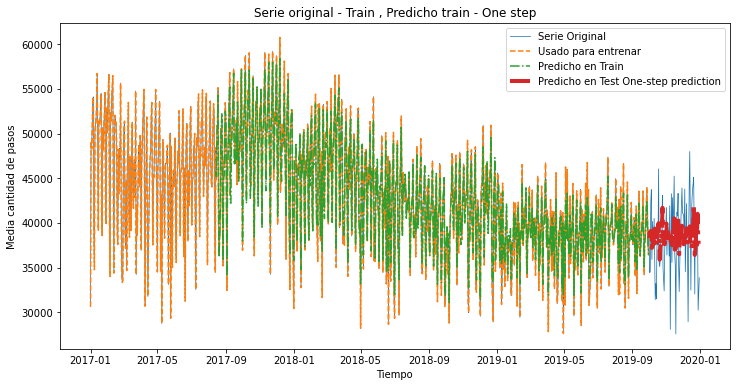

In [108]:
plt.figure(figsize=(12,6))
plt.plot(senial_livianos.index[:length_total_liviano], senial_livianos[:length_total_liviano],lw = 0.75, label = 'Serie Original')
plt.plot(senial_livianos.index[:N_train_liviano + look_back_livianos], senial_livianos[:N_train_liviano + look_back_livianos],'--', label = 'Usado para entrenar')
plt.plot(senial_livianos.index[look_back_livianos: look_back_livianos + N_train_liviano], y_train_pred_liv,'-.',label = 'Predicho en Train')
plt.plot(senial_livianos.index[N_train_liviano+look_back_livianos: length_total_liviano], y_test_pred_liv,'-.', lw = 4, label = 'Predicho en Test One-step prediction')
plt.legend()

plt.title('Serie original - Train , Predicho train - One step')
plt.xlabel('Tiempo')
plt.ylabel('Media cantidad de pasos')
plt.show()

In [109]:
#Benchmark
y_test_pred_benchmark = y_liv[-1 + N_train_liviano:N_train_liviano+N_test_liviano - 1]

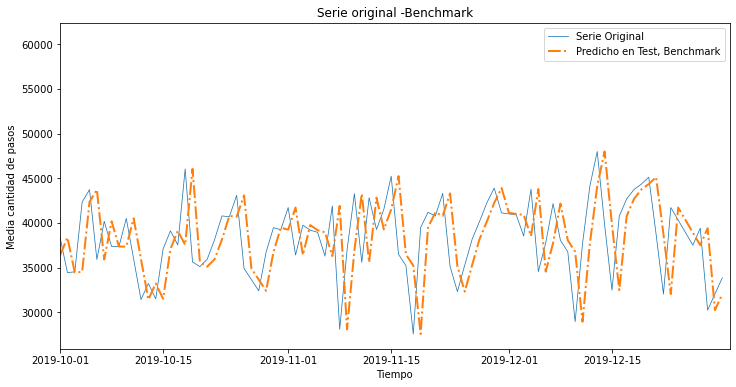

In [110]:
plt.figure(figsize=(12,6))
plt.plot(senial_livianos.index[:length_total_liviano], senial_livianos[:length_total_liviano],lw = 0.75, label = 'Serie Original')
plt.plot(senial_livianos.index[N_train_liviano+look_back_livianos: length_total_liviano], y_test_pred_benchmark,'-.', lw = 2, label = 'Predicho en Test, Benchmark')
plt.xlim(senial_livianos.index[N_train_liviano+look_back_livianos], senial_livianos.index[length_total_liviano])

plt.title('Serie original -Benchmark')
plt.xlabel('Tiempo')
plt.ylabel('Media cantidad de pasos')
plt.legend()
plt.show()

### Multi-Step Prediction livianos.

In [111]:
y_ms_test_pred_liv = []
x = X_test_liv[0,:] # arrancamos con la primera instancias del conjunto de test
for i in range(y_test_liv.size):
    y_os_pred = rf_livianos.predict(x.reshape(1,-1))
    y_ms_test_pred_liv.append(y_os_pred)
    x = np.append(x[1:], y_os_pred)
y_ms_test_pred_liv = np.array(y_ms_test_pred_liv)

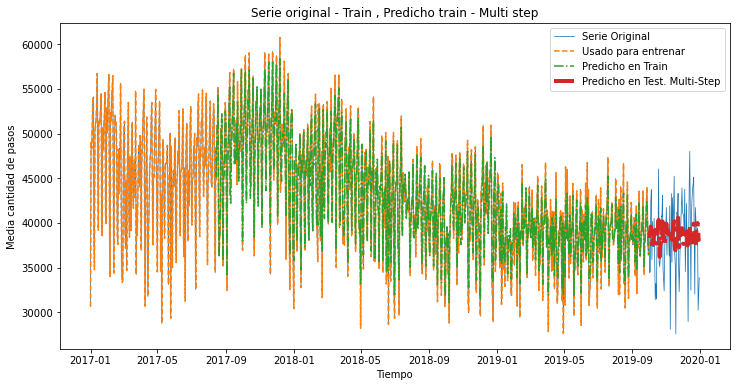

In [112]:
plt.figure(figsize=(12,6))
plt.plot(senial_livianos.index[:length_total_liviano], senial_livianos[:length_total_liviano],lw = 0.75, label = 'Serie Original')
plt.plot(senial_livianos.index[:N_train_liviano + look_back_livianos], senial_livianos[:N_train_liviano + look_back_livianos],'--', label = 'Usado para entrenar')
plt.plot(senial_livianos.index[look_back_livianos: look_back_livianos + N_train_liviano], y_train_pred_liv,'-.',label = 'Predicho en Train')
plt.plot(senial_livianos.index[N_train_liviano+look_back_livianos: length_total_liviano], y_ms_test_pred_liv,'-.', lw = 4, label = 'Predicho en Test. Multi-Step')
plt.legend()

plt.title('Serie original - Train , Predicho train - Multi step')
plt.xlabel('Tiempo')
plt.ylabel('Media cantidad de pasos')
plt.show()

In [113]:
#Presentamos el error cuadratico medio de cada uno de los modelos analizados

MSE_train_liv = mean_squared_error(y_train_liviano, y_train_pred_liv)
print('El error cuadratico medio en Train de los vehiculos livianos es de:',np.sqrt(MSE_train_liv).round(3))

MSE_test_liv = mean_squared_error(y_test_liv, y_test_pred_liv)
print('El error cuadratico medio en Test de los vehiculos livianos es de:',np.sqrt(MSE_test_liv).round(3))

y_test_pred_benchmark = y_liv[-1 + N_train_liviano:N_train_liviano+N_test_liviano - 1]
MSE_test_benchmark_liv = mean_squared_error(y_test_liv, y_liv[-1 + N_train_liviano:N_train_liviano+N_test_liviano - 1])
print('El error cuadratico medio del test en benchmark es de ', np.sqrt(MSE_test_benchmark_liv).round(3))

MSE_test_multistep_liv = mean_squared_error(y_test_liv, y_ms_test_pred_liv)
print('El error cuadratico medio en Test multi-step de los vehiculos livianos es de:',np.sqrt(MSE_test_multistep_liv).round(3))

El error cuadratico medio en Train de los vehiculos livianos es de: 1498.47
El error cuadratico medio en Test de los vehiculos livianos es de: 3710.647
El error cuadratico medio del test en benchmark es de  5060.384
El error cuadratico medio en Test multi-step de los vehiculos livianos es de: 3806.117


### Parte C

Conclusión pesados y livianos:
1. Si bien ambos tipo de vehiculos van disminuyento anualmente, obervamos que en los vehículos pesados es mas notorio. La tendencia global de la serie es decreciente y la misma no se mantiene 'recta' en el tiempo. En los livianos observamos que se mantiene mas estable a lo largo de los meses, en cambio en los pesados se observa como dismunuyen considerablemente.

Para continuar con el proyecto analizo las siguientes posibilidades:
1. Agregaría los dataset de años anteriores, analizaría sus datos y si corresponde los agregaría al modelado suponiendo que obtendríamos resultados mas acertados ya que el modelo posee mayor información.
1. Tendría en cuenta otros medios de pago ya que como vimos en un analisis preliminar hay incentivos a migrar al telepase.
Con ello observaría si obtendriamos predicciones mas certeras, ya que considero una variable clave el medio de pago.